# Creating an agreement predictor
In the previous notebooks we created a multilingual dataset made of pairs of claims/fact-checking articles. What we want to do now, is creating a model capable of predicting whether, given a claim and an article, the latter supports the former or refutes it.

We will be testing the model on different versions of the dataset

## Import

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
import shutil

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created

In [ ]:
def upload_from_drive(link, name):
  id = link.split('file/d/')[1].split('/view?usp=sharing')[0]
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(name) 

In [ ]:
!pip3 install -q tensorflow_gpu==2.3.0

     |████████████████████████████████| 320.4MB 52kB/s 


In [ ]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.3MB 134kB/s 
     |████████████████████████████████| 983kB 49.2MB/s 
     |████████████████████████████████| 266kB 48.4MB/s 
     |████████████████████████████████| 1.3MB 47.7MB/s 
     |████████████████████████████████| 471kB 46.4MB/s 
     |████████████████████████████████| 890kB 46.5MB/s 
     |████████████████████████████████| 1.1MB 41.1MB/s 
     |████████████████████████████████| 2.9MB 46.3MB/s 


In [ ]:
import tensorflow as tf
import ktrain
from ktrain import text
MODEL_NAME = 'bert-base-multilingual-uncased'
print(tf.__version__)
tf.test.gpu_device_name()

2.3.0


'/device:GPU:0'

## Retrieve the dataset
The dataset is saved on my Google Drive folder

In [ ]:
link = "https://drive.google.com/file/d/1h9kJCJu7JaW6jdtA7pWsO85r9rprluZJ/view?usp=sharing"
id = "1h9kJCJu7JaW6jdtA7pWsO85r9rprluZJ" 
name = "clean_final_factcheck_articles.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
df = pd.read_csv('clean_final_factcheck_articles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52420 entries, 0 to 52419
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   claim                       52420 non-null  object
 1   claimant                    45797 non-null  object
 2   claimDate                   45851 non-null  object
 3   url                         52420 non-null  object
 4   reviewTitle                 52227 non-null  object
 5   reviewDate                  51746 non-null  object
 6   Rating                      52420 non-null  object
 7   languageCode                52420 non-null  object
 8   publisherName               50906 non-null  object
 9   publisherSite               52420 non-null  object
 10  UniformRating               52420 non-null  object
 11  claimLink                   1401 non-null   object
 12  articleBody                 52420 non-null  object
 13  imageUrl                    52420 non-null  ob

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We won't be needing most of the columns for this task, so we can drop the ones we're not planning to use

In [ ]:
df = df.drop(df.columns.difference(['claim', 'reviewTitle', 'Rating', 'languageCode', 'language', 'articleBody', 'UniformRatingGraph', 'publisherSite']), axis=1)

In [ ]:
df['text'] = df['claim'] + ' [SEP] ' + df['articleBody']
df['target'] = df['UniformRatingGraph']

## Creating a predicting model
During our experiments, we saw that this is quite a difficult task for a machine learning model to learn. Whether this comes from the skewness of the dataset or from the ambiguity of the task itself, we need more tests to find out. In the next steps we'll try different approaches to the problem to see if it can be solved somehow.

### Base
The first approach is the one we were planning to use in the beginning: training a BERT model on the entire dataset. The model, if capable of tackling the task, should then have the great advantage of being able to solve the task in different languages, not just in English.

To help us in creating the BERT model, we will be using the *ktrain* library

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df, 
                                                                   text_column='text',
                                                                   label_columns=['target'],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1748/1748 [==============================] - 764s 437ms/step - loss: 0.4141 - accuracy: 0.8255
Epoch 2/5
1748/1748 [==============================] - 760s 435ms/step - loss: 0.3007 - accuracy: 0.8704
Epoch 3/5
1748/1748 [==============================] - 757s 433ms/step - loss: 0.5246 - accuracy: 0.7983
Epoch 4/5
1748/1748 [==============================] - 756s 433ms/step - loss: 1.5607 - accuracy: 0.7065


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


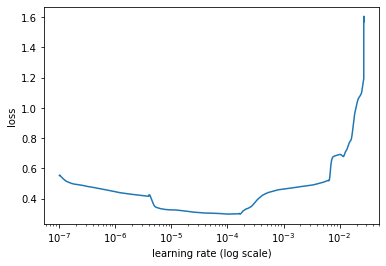

In [ ]:
#Find optimal learning rate
learner.lr_find(max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.fit_onecycle(5e-4, 2)

#Validate
learner.validate(class_names=t.get_classes())



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/2
1748/1748 [==============================] - 798s 457ms/step - loss: 0.4661 - accuracy: 0.8134 - val_loss: 0.5010 - val_accuracy: 0.8049
Epoch 2/2
1748/1748 [==============================] - 798s 457ms/step - loss: 0.4935 - accuracy: 0.8090 - val_loss: 0.4935 - val_accuracy: 0.8049
              precision    recall  f1-score   support

        True       0.80      1.00      0.89      8439
       False       0.00      0.00      0.00      2045

    accuracy                           0.80     10484
   macro avg       0.40      0.50      0.45     10484
weighted avg       0.65      0.80      0.72     10484



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[8439,    0],
       [2045,    0]])

As in our experiments, BERT overfits in this task. Anyway, we save the predictor for the moment.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
predictor.save('/tmp/agreement_predictor')

In [ ]:
save_file_to_drive('tf_model.h5', '/tmp/agreement_predictor/tf_model.h5')
save_file_to_drive('tf_model.preproc', '/tmp/agreement_predictor/tf_model.preproc')

File ID: 1cHj0OncM5F6eghDk5gkvoxYcBTdEDJTA
File ID: 1GG6OskcwFO9AIoapLTVsm9OWeb67LdXU


{'id': '1GG6OskcwFO9AIoapLTVsm9OWeb67LdXU'}

### Last layer frozen
We train BERT again on the same dataset, but we freeze all of BERT's weights. We only let the last layer (the classifier) to be trained.

In [ ]:
df['text'] = df['claim'] + ' [SEP] ' + df['articleBody']
df['target'] = df['UniformRatingGraph']

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df, 
                                                                   text_column='text',
                                                                   label_columns=['target'],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


In [ ]:
learner.freeze()

In [ ]:
#Fit model
learner.fit_onecycle(5e-4, 5)



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/5
1748/1748 [==============================] - 186s 107ms/step - loss: 0.4690 - accuracy: 0.8093 - val_loss: 0.4521 - val_accuracy: 0.8006
Epoch 2/5
1748/1748 [==============================] - 183s 105ms/step - loss: 0.4294 - accuracy: 0.8130 - val_loss: 0.4258 - val_accuracy: 0.8087
Epoch 3/5
1748/1748 [==============================] - 183s 104ms/step - loss: 0.4131 - accuracy: 0.8202 - val_loss: 0.4122 - val_accuracy: 0.8160
Epoch 4/5
1748/1748 [==============================] - 183s 105ms/step - loss: 0.4029 - accuracy: 0.8255 - val_loss: 0.4043 - val_accuracy: 0.8233
Epoch 5/5
1748/1748 [==============================] - 183s 104ms/step - loss: 0.3982 - accuracy: 0.8271 - val_loss: 0.4032 - val_accuracy: 0.8244


NameError: ignored

In [ ]:

#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      8387
           1       0.67      0.24      0.35      2097

    accuracy                           0.82     10484
   macro avg       0.75      0.61      0.63     10484
weighted avg       0.80      0.82      0.79     10484



array([[8138,  249],
       [1592,  505]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
predictor.save('/tmp/agreement_predictor_frozen')

In [ ]:
save_file_to_drive('tf_model.h5', '/tmp/agreement_predictor_frozen/tf_model.h5')
save_file_to_drive('tf_model.preproc', '/tmp/agreement_predictor_frozen/tf_model.preproc')

File ID: 1khBS3CHWQKj2P82Y1idxg9dg_Bp55Yyq
File ID: 1b17_O7j_IiXHfQhVFSd6gzWHdvM-lxQX


{'id': '1b17_O7j_IiXHfQhVFSd6gzWHdvM-lxQX'}

### Smaller balanced dataset
We cut the dataset false rows to create a balanced dataset to see whether this helps BERT

In [ ]:
df_false = df[df['target'] == False].sample(frac=0.25)
df_true = df[df['target'] == True]
df_balanced = pd.concat([df_true, df_false])

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_balanced, 
                                                                   text_column='text',
                                                                   label_columns=['target'],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
689/689 [==============================] - 310s 449ms/step - loss: 0.6947 - accuracy: 0.6046
Epoch 2/5
689/689 [==============================] - 306s 444ms/step - loss: 0.4798 - accuracy: 0.7860
Epoch 3/5
689/689 [==============================] - 306s 443ms/step - loss: 0.7513 - accuracy: 0.5462
Epoch 4/5
689/689 [==============================] - 304s 442ms/step - loss: 2.9031 - accuracy: 0.5021


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


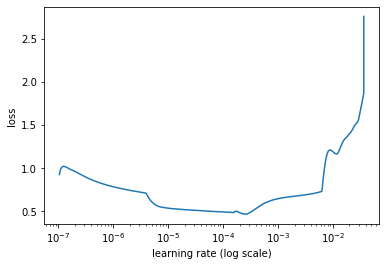

In [ ]:
learner.lr_find(max_epochs=5)
learner.lr_plot()

In [ ]:
#Fit model
learner.fit_onecycle(5e-4, 5)

#Validate
learner.validate(class_names=t.get_classes())



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/5
689/689 [==============================] - 312s 453ms/step - loss: 0.5586 - accuracy: 0.7093 - val_loss: 0.7209 - val_accuracy: 0.5131
Epoch 2/5
689/689 [==============================] - 309s 448ms/step - loss: 0.7063 - accuracy: 0.5003 - val_loss: 0.7067 - val_accuracy: 0.4869
Epoch 3/5
689/689 [==============================] - 308s 447ms/step - loss: 0.7061 - accuracy: 0.5033 - val_loss: 0.6930 - val_accuracy: 0.5131
Epoch 4/5
689/689 [==============================] - 308s 447ms/step - loss: 0.7012 - accuracy: 0.5046 - val_loss: 0.6931 - val_accuracy: 0.5131
Epoch 5/5
689/689 [==============================] - 308s 447ms/step - loss: 0.6959 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.4869
              precision    recall  f1-score   support

        True       0.00      0.00      0.00      2119
       False       0.49      1.00      0.65      2011

    accuracy                           0.49    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0, 2119],
       [   0, 2011]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
predictor.save('/tmp/agreement_predictor_balanced')

In [ ]:
save_file_to_drive('tf_model.h5', '/tmp/agreement_predictor_balanced/tf_model.h5')
save_file_to_drive('tf_model.preproc', '/tmp/agreement_predictor_balanced/tf_model.preproc')

File ID: 19cs9tgrqCOYTCmgAD93sBuU5_4l0bwp-
File ID: 1jGe0V0_xeyE1UKjLfyAMo7YbIuPdrhuK


{'id': '1jGe0V0_xeyE1UKjLfyAMo7YbIuPdrhuK'}

### Smaller balanced dataset, frozen layers
We try again to train a BERT model, but this time we cut the dataset to make it more balanced

In [ ]:
df_false = df[df['target'] == False].sample(frac=0.25)
df_true = df[df['target'] == True]
df_balanced = pd.concat([df_true, df_false])

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_balanced, 
                                                                   text_column='text',
                                                                   label_columns=['target'],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


In [ ]:
learner.freeze()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
689/689 [==============================] - 58s 84ms/step - loss: 0.7003 - accuracy: 0.5248
Epoch 2/5
689/689 [==============================] - 58s 84ms/step - loss: 0.6876 - accuracy: 0.5623
Epoch 3/5
689/689 [==============================] - 58s 84ms/step - loss: 0.6414 - accuracy: 0.6395
Epoch 4/5
689/689 [==============================] - 58s 85ms/step - loss: 2.2530 - accuracy: 0.6117
Epoch 5/5
689/689 [==============================] - 58s 84ms/step - loss: 7.0461 - accuracy: 0.6274


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


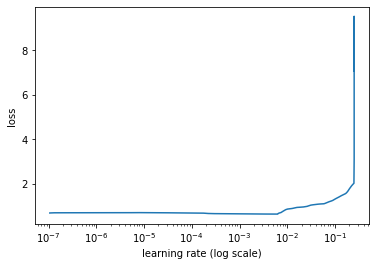

In [ ]:
learner.lr_find(max_epochs=5)
learner.lr_plot()

In [ ]:
#Fit model
learner.fit_onecycle(5e-4, 5)

#Validate
learner.validate()



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/5
689/689 [==============================] - 76s 110ms/step - loss: 0.6608 - accuracy: 0.6039 - val_loss: 0.6356 - val_accuracy: 0.6479
Epoch 2/5
689/689 [==============================] - 72s 104ms/step - loss: 0.6197 - accuracy: 0.6647 - val_loss: 0.5972 - val_accuracy: 0.6949
Epoch 3/5
689/689 [==============================] - 72s 105ms/step - loss: 0.5910 - accuracy: 0.6918 - val_loss: 0.5824 - val_accuracy: 0.7019
Epoch 4/5
689/689 [==============================] - 72s 104ms/step - loss: 0.5781 - accuracy: 0.7030 - val_loss: 0.5715 - val_accuracy: 0.7085
Epoch 5/5
689/689 [==============================] - 72s 104ms/step - loss: 0.5696 - accuracy: 0.7113 - val_loss: 0.5695 - val_accuracy: 0.7104
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      2142
           1       0.67      0.77      0.72      1988

    accuracy                           0.71      413

array([[1397,  745],
       [ 451, 1537]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
predictor.save('/tmp/agreement_predictor_balanced')

In [ ]:
save_file_to_drive('tf_model.h5', '/tmp/agreement_predictor_balanced/tf_model.h5')
save_file_to_drive('tf_model.preproc', '/tmp/agreement_predictor_balanced/tf_model.preproc')

File ID: 19cs9tgrqCOYTCmgAD93sBuU5_4l0bwp-
File ID: 1jGe0V0_xeyE1UKjLfyAMo7YbIuPdrhuK


{'id': '1jGe0V0_xeyE1UKjLfyAMo7YbIuPdrhuK'}

### Claim vs reviewTitle
Another BERT model, but this time it's only claim + reviewTitle, without the actual article body

Since freezing the last layer gave a model that was much faster to train and returned better results, we make this test in the same way.

In [ ]:
df['text'] = df['claim'] + ' [SEP] ' + df['reviewTitle']

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df, 
                                                                   text_column='text',
                                                                   label_columns=['target'],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128


Exception ignored in: <bound method MediaFileUpload.__del__ of <googleapiclient.http.MediaFileUpload object at 0x7f3fa4e71b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/http.py", line 578, in __del__
    self._fd.close()
AttributeError: 'MediaFileUpload' object has no attribute '_fd'


done.


In [ ]:
learner.freeze()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1748/1748 [==============================] - 145s 83ms/step - loss: 0.5832 - accuracy: 0.7698
Epoch 2/5
1748/1748 [==============================] - 145s 83ms/step - loss: 0.4848 - accuracy: 0.8074
Epoch 3/5
1748/1748 [==============================] - 145s 83ms/step - loss: 0.4604 - accuracy: 0.8073
Epoch 4/5
1748/1748 [==============================] - 145s 83ms/step - loss: 1.8042 - accuracy: 0.7497
Epoch 5/5
1748/1748 [==============================] - 145s 83ms/step - loss: 5.0100 - accuracy: 0.7481


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


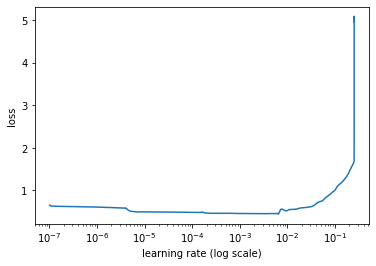

In [ ]:
learner.lr_find(max_epochs=5)
learner.lr_plot()

In [ ]:
#Fit model
learner.fit_onecycle(5e-4, 5)

#Validate
learner.validate(class_names=t.get_classes())



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/5
1748/1748 [==============================] - 184s 105ms/step - loss: 0.4689 - accuracy: 0.8081 - val_loss: 0.4772 - val_accuracy: 0.8057
Epoch 2/5
1748/1748 [==============================] - 180s 103ms/step - loss: 0.4442 - accuracy: 0.8116 - val_loss: 0.4284 - val_accuracy: 0.8137
Epoch 3/5
1748/1748 [==============================] - 180s 103ms/step - loss: 0.4289 - accuracy: 0.8163 - val_loss: 0.4176 - val_accuracy: 0.8162
Epoch 4/5
1748/1748 [==============================] - 180s 103ms/step - loss: 0.4186 - accuracy: 0.8190 - val_loss: 0.4116 - val_accuracy: 0.8183
Epoch 5/5
1748/1748 [==============================] - 180s 103ms/step - loss: 0.4129 - accuracy: 0.8206 - val_loss: 0.4095 - val_accuracy: 0.8188
              precision    recall  f1-score   support

        True       0.83      0.98      0.90      8458
       False       0.66      0.13      0.22      2026

    accuracy                         

array([[8318,  140],
       [1760,  266]])

### Claim vs reviewTitle - balanced dataset
We combine the two previous approaches, limiting the model training to the claim and title columns, on a balanced dataset.

In [ ]:
df['text'] = df['claim'] + ' [SEP] ' + df['reviewTitle']

In [ ]:
df_false = df[df['target'] == False].sample(frac=0.25)
df_true = df[df['target'] == True]
df_balanced = pd.concat([df_true, df_false])

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df_balanced, 
                                                                   text_column='text',
                                                                   label_columns=['target'],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=3)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


In [ ]:
learner.freeze()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
689/689 [==============================] - 310s 450ms/step - loss: 0.6828 - accuracy: 0.6332
Epoch 2/5
689/689 [==============================] - 307s 446ms/step - loss: 0.4695 - accuracy: 0.7936
Epoch 3/5
689/689 [==============================] - 307s 446ms/step - loss: 0.6661 - accuracy: 0.5835
Epoch 4/5
689/689 [==============================] - 306s 444ms/step - loss: 4.3766 - accuracy: 0.5041


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


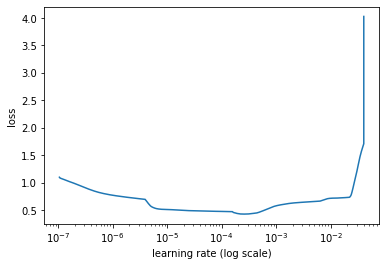

In [ ]:
learner.lr_find(max_epochs=5)
learner.lr_plot()

In [ ]:
#Fit model
learner.fit_onecycle(5e-4, 5)

#Validate
learner.validate(class_names=preproc.get_classes())



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/5
689/689 [==============================] - 74s 107ms/step - loss: 0.6728 - accuracy: 0.5822 - val_loss: 0.6531 - val_accuracy: 0.6189
Epoch 2/5
689/689 [==============================] - 70s 102ms/step - loss: 0.6381 - accuracy: 0.6352 - val_loss: 0.6192 - val_accuracy: 0.6528
Epoch 3/5
689/689 [==============================] - 71s 103ms/step - loss: 0.6147 - accuracy: 0.6584 - val_loss: 0.6044 - val_accuracy: 0.6605
Epoch 4/5
689/689 [==============================] - 71s 103ms/step - loss: 0.6012 - accuracy: 0.6723 - val_loss: 0.5927 - val_accuracy: 0.6847
Epoch 5/5
689/689 [==============================] - 71s 103ms/step - loss: 0.5921 - accuracy: 0.6787 - val_loss: 0.5908 - val_accuracy: 0.6828
              precision    recall  f1-score   support

  not_target       0.74      0.61      0.67      2148
      target       0.64      0.77      0.70      1982

    accuracy                           0.68      413

array([[1303,  845],
       [ 465, 1517]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
predictor.save('/tmp/agreement_predictor_review_balanced')

In [ ]:
save_file_to_drive('tf_model.h5', '/tmp/agreement_predictor_review_balanced/tf_model.h5')
save_file_to_drive('tf_model.preproc', '/tmp/agreement_predictor_review_balanced/tf_model.preproc')

File ID: 1cT94SSesIT4i_9iUsVaU1pu4kYYu2S04
File ID: 1QdYmsB7YfzqpVrR1LxUK92_iE_4XOudO


{'id': '1QdYmsB7YfzqpVrR1LxUK92_iE_4XOudO'}

## Testing the model

We test the model against the FNC-1 dataset for agreement detection

In [ ]:
#Functions that returns the predictions over a test dataframe for a ktrain predictor
def return_predictions(df, predictor, text_column="text"):
  print(text_column)
  predictions = []
  
  total = len(df)
  completed = 0
  one_percent = int(total/100)

  for row in df[text_column]:
    prediction = predictor.predict(row)
    predictions.append(prediction)
    if completed % one_percent == 0:
      print("Percentage completion: {:.2f}%".format(completed*100/total))
    completed += 1
  return predictions

### Download the FNC-1 dataset

In [ ]:
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_stances.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_bodies.csv

--2020-11-13 18:02:38--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_stances.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2177588 (2.1M) [text/plain]
Saving to: ‘competition_test_stances.csv’

competition_test_st 100%[===================>]   2.08M  --.-KB/s    in 0.08s   

2020-11-13 18:02:42 (24.6 MB/s) - ‘competition_test_stances.csv’ saved [2177588/2177588]

--2020-11-13 18:02:42--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_bodies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaitin

In [ ]:
df_stance = pd.read_csv('competition_test_stances.csv')
df_bodies = pd.read_csv('competition_test_bodies.csv')

In [ ]:
df_stance.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [ ]:
df_bodies.head()

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [ ]:
df_test = pd.merge(left=df_stance, right=df_bodies, on='Body ID')

In [ ]:
df_test.head()

,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...
1,Apple Stores to install safes to secure gold A...,2008,unrelated,A RESPECTED senior French police officer inves...
2,Pregnant woman loses eye after police shoot be...,2008,unrelated,A RESPECTED senior French police officer inves...
3,We just found out the #Ferguson Protester who ...,2008,unrelated,A RESPECTED senior French police officer inves...
4,Police Chief In Charge of Paris Attacks Commit...,2008,discuss,A RESPECTED senior French police officer inves...


In [ ]:
df_test['Stance'].unique()

array(['unrelated', 'discuss', 'agree', 'disagree'], dtype=object)

In [ ]:
df_test = df_test[df_test['Stance'].isin(['agree','disagree'])]

In [ ]:
df_test['text'] = df_test['Headline'] + ' [SEP] ' + df_test['articleBody']

### BERT model - Base dataset, last layer frozen

In [ ]:
upload_from_drive('https://drive.google.com/file/d/19cs9tgrqCOYTCmgAD93sBuU5_4l0bwp-/view?usp=sharing', 'tf_model.h5')
upload_from_drive('https://drive.google.com/file/d/1jGe0V0_xeyE1UKjLfyAMo7YbIuPdrhuK/view?usp=sharing', 'tf_model.preproc')

In [ ]:
predictor = ktrain.load_predictor('/tmp/agreement_predictor_frozen')

In [ ]:
df_test['result_base'] = return_predictions(df_test, predictor)

text


Percentage completion: 0.00%


Percentage completion: 1.00%


Percentage completion: 2.00%


Percentage completion: 3.00%


Percentage completion: 4.00%


Percentage completion: 5.00%


Percentage completion: 6.00%


Percentage completion: 7.00%


Percentage completion: 8.00%


Percentage completion: 9.00%


Percentage completion: 10.00%


Percentage completion: 11.00%


Percentage completion: 12.00%


Percentage completion: 13.00%


Percentage completion: 14.00%


Percentage completion: 15.00%


Percentage completion: 16.00%


Percentage completion: 17.00%


Percentage completion: 18.00%


Percentage completion: 19.00%


Percentage completion: 20.00%


Percentage completion: 21.00%


Percentage completion: 22.00%


Percentage completion: 23.00%


Percentage completion: 24.00%


Percentage completion: 25.00%


Percentage completion: 26.00%


Percentage completion: 27.00%


Percentage completion: 28.00%


Percentage completion: 29.00%


Percentage completion: 30.00%


Percentage completion: 31.00%


Percentage completion: 32.00%


Percentage completion: 33.00%


Percentage completion: 34.00%


Percentage completion: 35.00%


Percentage completion: 36.00%


Percentage completion: 37.00%


Percentage completion: 38.00%


Percentage completion: 39.00%


Percentage completion: 40.00%


Percentage completion: 41.00%


Percentage completion: 42.00%


Percentage completion: 43.00%


Percentage completion: 44.00%


Percentage completion: 45.00%


Percentage completion: 46.00%


Percentage completion: 47.00%


Percentage completion: 48.00%


Percentage completion: 49.00%


Percentage completion: 50.00%


Percentage completion: 51.00%


Percentage completion: 52.00%


Percentage completion: 53.00%


Percentage completion: 54.00%


Percentage completion: 55.00%


Percentage completion: 56.00%


Percentage completion: 57.00%


Percentage completion: 58.00%


Percentage completion: 59.00%


Percentage completion: 60.00%


Percentage completion: 61.00%


Percentage completion: 62.00%


Percentage completion: 63.00%


Percentage completion: 64.00%


Percentage completion: 65.00%


Percentage completion: 66.00%


Percentage completion: 67.00%


Percentage completion: 68.00%


Percentage completion: 69.00%


Percentage completion: 70.00%


Percentage completion: 71.00%


Percentage completion: 72.00%


Percentage completion: 73.00%


Percentage completion: 74.00%


Percentage completion: 75.00%


Percentage completion: 76.00%


Percentage completion: 77.00%


Percentage completion: 78.00%


Percentage completion: 79.00%


Percentage completion: 80.00%


Percentage completion: 81.00%


Percentage completion: 82.00%


Percentage completion: 83.00%


Percentage completion: 84.00%


Percentage completion: 85.00%


Percentage completion: 86.00%


Percentage completion: 87.00%


Percentage completion: 88.00%


Percentage completion: 89.00%


Percentage completion: 90.00%


Percentage completion: 91.00%


Percentage completion: 92.00%


Percentage completion: 93.00%


Percentage completion: 94.00%


Percentage completion: 95.00%


Percentage completion: 96.00%


Percentage completion: 97.00%


Percentage completion: 98.00%


Percentage completion: 99.00%


In [ ]:
df_test['result_base'] = df_test['result_base'].apply(lambda row: 'disagree' if row == 'not_target' else 'agree')

In [ ]:
print(confusion_matrix(df_test['Stance'], df_test['result_base']))
print(classification_report(df_test['Stance'], df_test['result_base']))

[[  38 1865]
 [  14  683]]
              precision    recall  f1-score   support

       agree       0.73      0.02      0.04      1903
    disagree       0.27      0.98      0.42       697

    accuracy                           0.28      2600
   macro avg       0.50      0.50      0.23      2600
weighted avg       0.61      0.28      0.14      2600



### BERT model - Balanced dataset, last layer frozen

In [ ]:
upload_from_drive('https://drive.google.com/file/d/19cs9tgrqCOYTCmgAD93sBuU5_4l0bwp-/view?usp=sharing', 'tf_model.h5')
upload_from_drive('https://drive.google.com/file/d/1jGe0V0_xeyE1UKjLfyAMo7YbIuPdrhuK/view?usp=sharing', 'tf_model.preproc')

In [ ]:
predictor = ktrain.load_predictor('/tmp/agreement_predictor_balanced')

In [ ]:
df_test['result_balanced'] = return_predictions(df_test, predictor)

text


Percentage completion: 0.00%


Percentage completion: 1.00%


Percentage completion: 2.00%


Percentage completion: 3.00%


Percentage completion: 4.00%


Percentage completion: 5.00%


Percentage completion: 6.00%


Percentage completion: 7.00%


Percentage completion: 8.00%


Percentage completion: 9.00%


Percentage completion: 10.00%


Percentage completion: 11.00%


Percentage completion: 12.00%


Percentage completion: 13.00%


Percentage completion: 14.00%


Percentage completion: 15.00%


Percentage completion: 16.00%


Percentage completion: 17.00%


Percentage completion: 18.00%


Percentage completion: 19.00%


Percentage completion: 20.00%


Percentage completion: 21.00%


Percentage completion: 22.00%


Percentage completion: 23.00%


Percentage completion: 24.00%


Percentage completion: 25.00%


Percentage completion: 26.00%


Percentage completion: 27.00%


Percentage completion: 28.00%


Percentage completion: 29.00%


Percentage completion: 30.00%


Percentage completion: 31.00%


Percentage completion: 32.00%


Percentage completion: 33.00%


Percentage completion: 34.00%


Percentage completion: 35.00%


Percentage completion: 36.00%


Percentage completion: 37.00%


Percentage completion: 38.00%


Percentage completion: 39.00%


Percentage completion: 40.00%


Percentage completion: 41.00%


Percentage completion: 42.00%


Percentage completion: 43.00%


Percentage completion: 44.00%


Percentage completion: 45.00%


Percentage completion: 46.00%


Percentage completion: 47.00%


Percentage completion: 48.00%


Percentage completion: 49.00%


Percentage completion: 50.00%


Percentage completion: 51.00%


Percentage completion: 52.00%


Percentage completion: 53.00%


Percentage completion: 54.00%


Percentage completion: 55.00%


Percentage completion: 56.00%


Percentage completion: 57.00%


Percentage completion: 58.00%


Percentage completion: 59.00%


Percentage completion: 60.00%


Percentage completion: 61.00%


Percentage completion: 62.00%


Percentage completion: 63.00%


Percentage completion: 64.00%


Percentage completion: 65.00%


Percentage completion: 66.00%


Percentage completion: 67.00%


Percentage completion: 68.00%


Percentage completion: 69.00%


Percentage completion: 70.00%


Percentage completion: 71.00%


Percentage completion: 72.00%


Percentage completion: 73.00%


Percentage completion: 74.00%


Percentage completion: 75.00%


Percentage completion: 76.00%


Percentage completion: 77.00%


Percentage completion: 78.00%


Percentage completion: 79.00%


Percentage completion: 80.00%


Percentage completion: 81.00%


Percentage completion: 82.00%


Percentage completion: 83.00%


Percentage completion: 84.00%


Percentage completion: 85.00%


Percentage completion: 86.00%


Percentage completion: 87.00%


Percentage completion: 88.00%


Percentage completion: 89.00%


Percentage completion: 90.00%


Percentage completion: 91.00%


Percentage completion: 92.00%


Percentage completion: 93.00%


Percentage completion: 94.00%


Percentage completion: 95.00%


Percentage completion: 96.00%


Percentage completion: 97.00%


Percentage completion: 98.00%


Percentage completion: 99.00%


In [ ]:
df_test['result_balanced'] = df_test['result_balanced'].apply(lambda row: 'disagree' if row == 'not_target' else 'agree')

In [ ]:
print(confusion_matrix(df_test['Stance'], df_test['result_balanced']))
print(classification_report(df_test['Stance'], df_test['result_balanced']))

[[ 551 1352]
 [ 160  537]]
              precision    recall  f1-score   support

       agree       0.77      0.29      0.42      1903
    disagree       0.28      0.77      0.42       697

    accuracy                           0.42      2600
   macro avg       0.53      0.53      0.42      2600
weighted avg       0.64      0.42      0.42      2600

